### Universidad de los Andes
#### MIIA4200_1
##### Juan Camilo Angarita Villamizar

Random Forest
________________________________________________________

# Exercise 11

## Car Price Prediction

Predict if the price of a car is low or high

In [1]:
%matplotlib inline
import pandas as pd

data = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTrain_carListings.zip')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [2]:
data.shape

(13150, 10)

In [3]:
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# Exercise 11.1

Estimate a Decision Tree Classifier Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [5]:
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001

In [9]:
j = 1
print(X_train.columns[j])

Mileage


In [10]:
import pandas as pd
import numpy as np

# Split the variable in num_ctp points
splits = np.percentile(X_train.iloc[:, j], np.arange(0, 100, 100.0 / num_pct).tolist())

In [11]:
splits = np.unique(splits)

In [12]:
splits

array([6.000000e+00, 1.603480e+04, 2.324080e+04, 2.987540e+04,
       3.565100e+04, 4.160950e+04, 4.849280e+04, 6.199830e+04,
       8.097420e+04, 1.061537e+05])

In [13]:
k = 5

In [14]:
filter_l = X_train.iloc[:, j] < splits[k]

y_l = y_train.loc[filter_l]
y_r = y_train.loc[~filter_l]

##### Gini
The Gini Impurity of a node is the probability that a randomly chosen sample in a node would be incorrectly labeled if it was labeled by the distribution of samples in the node.

For each node

In [21]:
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [22]:
gini_l = gini(y_l)
gini_l

0.20474618023837854

In [23]:
gini_r = gini(y_r)
gini_r

0.3959988713681828


The gini impurity of the split is the Gini Impurity of each node is weighted by the fraction of points from the parent node in that node.

##### putting all in a function

In [24]:
def gini_impurity(X_col, y, split):
    "Calculate the gain of an split k on feature j"
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [25]:
gini_impurity(X_train.iloc[:, j], y_train, splits[k])

0.4878029429461156


#### test all splits on all features

In [26]:
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [27]:
j, split, gain = best_split(X_train, y_train, 5)
j, split, gain

(0, 2011.0, 0.4878029429461156)

In [28]:
filter_l = X_train.iloc[:, j] < split

y_l = y_train.loc[filter_l]
y_r = y_train.loc[~filter_l]

In [29]:

y.shape[0], y_l.shape[0], y_r.shape[0]

(13150L, 1356L, 7454L)

In [30]:
y.mean(), y_l.mean(), y_r.mean()

(0.5795437262357415, 0.008112094395280236, 0.6817815937751542)

In [33]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [34]:
tree=tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=4, num_pct=10)

In [35]:
tree

{'gain': 0.4878029429461156,
 'level': 0,
 'n_samples': 8810,
 'sl': {'gain': 0.005813904070582909,
  'level': 1,
  'n_samples': 686,
  'sl': {'gain': 0,
   'level': 2,
   'n_samples': 60,
   'split': -1,
   'y_pred': 0,
   'y_prob': 0.016129032258064516},
  'split': [0, 2004.0],
  'sr': {'gain': 0.006369361736876078,
   'level': 2,
   'n_samples': 626,
   'sl': {'gain': 0,
    'level': 3,
    'n_samples': 54,
    'split': -1,
    'y_pred': 0,
    'y_prob': 0.017857142857142856},
   'split': [0, 2005.0],
   'sr': {'gain': 0.00696855591960488,
    'level': 3,
    'n_samples': 572,
    'sl': {'gain': 0,
     'level': 4,
     'n_samples': 114,
     'split': -1,
     'y_pred': 0,
     'y_prob': 0.008620689655172414},
    'split': [0, 2006.0],
    'sr': {'gain': 0.008695486356095516,
     'level': 4,
     'n_samples': 458,
     'split': -1,
     'y_pred': 0,
     'y_prob': 0.006521739130434782},
    'y_pred': 0,
    'y_prob': 0.005226480836236934},
   'y_pred': 0,
   'y_prob': 0.00477707006

In [38]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [47]:
y_pred=tree_predict(X_test, tree)

In [48]:
y_pred

array([0., 1., 1., ..., 1., 1., 0.])

In [49]:
from sklearn import metrics
metrics.accuracy_score(y_pred, y_test)


0.8334101382488479

___________________________________________________

# Exercise 11.2

Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [50]:
# set a seed for reproducibility
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10

# create ten bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([3582, 1346, 5218, ..., 5288, 5094, 8043]),
 array([ 431, 3426, 8463, ..., 8218,  237, 8326]),
 array([8477, 4773, 5743, ..., 1809,  214, 6910]),
 array([5885, 1492, 7249, ..., 1834,  137, 7586]),
 array([ 352, 4574, 5708, ..., 7142, 2081, 7438]),
 array([2311, 6342, 4124, ..., 8286, 8453, 1222]),
 array([5003, 7878, 7832, ..., 3522,  407, 3676]),
 array([6901, 1829, 1437, ..., 8100, 3585,  522]),
 array([2874, 2197, 2888, ...,  477, 5922, 4068]),
 array([5547, 7784, 7473, ..., 4908, 6648, 3622])]

In [51]:
# DataFrame for storing predicted price from each tree
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

# grow one tree for each bootstrap sample and make predictions on testing data
for i, sample in enumerate(samples):
    X_train_ = X_train.iloc[samples[i]]
    y_train_ = y_train.iloc[samples[i]]
    tree=tree_grow(X_train_, y_train_, level=0, min_gain=0.001, max_depth=4, num_pct=10)
    y_pred[i]=tree_predict(X_test, tree)


In [52]:
y_pred.head(5)

,0,1,2,3,4,5,6,7,8,9
332784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146436,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
130476,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
85618,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
75474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
for i in range(n_B):
    print(i, metrics.accuracy_score(y_pred[i], y_test))

(0, 0.8334101382488479)
(1, 0.8495391705069124)
(2, 0.8334101382488479)
(3, 0.8495391705069124)
(4, 0.8334101382488479)
(5, 0.8334101382488479)
(6, 0.8334101382488479)
(7, 0.8495391705069124)
(8, 0.8334101382488479)
(9, 0.8334101382488479)


In [55]:
y_pred_final = (y_pred.sum(axis=1) >= (n_B / 2)).astype(np.int)

In [57]:
print("F1_Score:",metrics.f1_score(y_pred_final, y_test))
print("Accuracy_Score:",metrics.accuracy_score(y_pred_final, y_test))

('F1_Score:', 0.8729573010015815)
('Accuracy_Score:', 0.8334101382488479)


El metodo Bagging mejoro el modelo

_______________________________________________________________________

# Exercise 11.3

Implement the variable max_features on the Decision Tree Classifier created in 11.1.

Compare the impact in the results by varing the parameter max_features

Evaluate the accuracy on the testing set

In [58]:
def tree_grow_max(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10,max_features=9):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    s_index = np.random.choice(a=X.shape[1], size=max_features, replace=False)
    X_sample=X.iloc[:, s_index]
    j, split, gain = best_split(X_sample, y, num_pct)
    j=s_index[j]
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Next iteration to each split
    
    tree['sl'] = tree_grow_max(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct,max_features=max_features)
    tree['sr'] = tree_grow_max(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct,max_features=max_features)
    
    return tree

In [59]:
tree=tree_grow_max(X_train, y_train, level=0, min_gain=0.001, max_depth=4, num_pct=10, max_features=3)
y_pred=tree_predict(X_test, tree)

In [60]:
metrics.accuracy_score(y_pred, y_test)

0.7663594470046083

In [61]:
features = range(1, X_train.shape[1]+1)
# list to store the average Accuracy for each value of max_features
accuracy = []
plot_accu = []

for feature in features:
    tree=tree_grow_max(X_train, y_train, level=0, min_gain=0.001, max_depth=4, num_pct=10, max_features=feature)
    y_pred=tree_predict(X_test, tree)
    accuracy.append([feature, metrics.accuracy_score(y_pred, y_test), metrics.f1_score(y_pred, y_test)])
    plot_accu.append(metrics.accuracy_score(y_pred, y_test))
    
accuracy=pd.DataFrame(accuracy, columns=['feature', 'Accuracy','F1Sco']) 
accuracy

,feature,Accuracy,F1Sco
0,1,0.728341,0.809931
1,2,0.718894,0.728527
2,3,0.761751,0.816014
3,4,0.778571,0.827685
4,5,0.761060,0.828906
5,6,0.810369,0.857192
6,7,0.728111,0.810594
7,8,0.744009,0.818553
8,9,0.728111,0.809800


Text(0,0.5,'Accuracy')

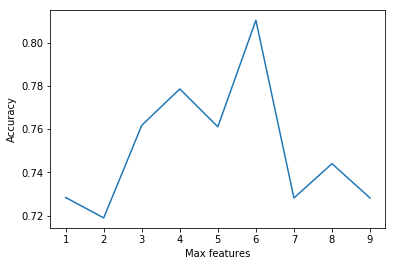

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(features, plot_accu)
plt.xlabel('Max features')
plt.ylabel('Accuracy')

________________________________________________________________________________

# Exercise 11.4

Estimate a Bagging of 10 Decision Tree Classifiers with `max_features = log(n_features)`

Evaluate the accuracy on the testing set

In [64]:
# set a seed for reproducibility
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10

# create ten bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

#seeds = np.random.randint(1, 10000, size=n_B)
# Predict Arboles
y_pred_df_trees = pd.DataFrame(index=X_test.index, columns=list(range(n_B)))
trees = {}
for i in range(10):
    trees[i] = tree_grow_max(X_train.iloc[samples[i]], y_train.iloc[samples[i]], level=0, min_gain=0.001, max_depth=4, num_pct=10,max_features=int(np.log(X_train.shape[1]+1)))
    y_pred_df_trees.iloc[:, i] = tree_predict(X_test, trees[i])
    
y_pred = (y_pred_df_trees.sum(axis=1) >= (n_B / 2)).astype(np.int)



In [66]:
print("F1_Score:",metrics.f1_score(y_pred, y_test))
print("Accuracy_Score:",metrics.accuracy_score(y_pred, y_test))

('F1_Score:', 0.8201110022853412)
('Accuracy_Score:', 0.7460829493087557)


____________________________________________________________________________________

# Exercise 11.5

Using sklearn, train a RandomForestClassifier

Evaluate the accuracy on the testing set

In [69]:
# use 10-fold cross-validation with each value of max_depth
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10, random_state=1, n_jobs=-1)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)


In [72]:
print('F1_Score:',metrics.f1_score(y_pred, y_test))
print("Accuracy_Score:",metrics.accuracy_score(y_pred, y_test))

('F1_Score:', 0.8615751789976134)
('Accuracy_Score:', 0.83963133640553)


______________________________________________________________________________

# Exercise 11.6

Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators)

Evaluate the accuracy on the testing set

Primero el número de estimadores:

In [71]:
from sklearn.model_selection import cross_val_score
# list of values to try for n_estimators
estimator_range = range(10, 310, 10)

# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

In [73]:
estima=pd.DataFrame(accuracy_scores, columns=['Accuracy'], index=range(10, 310, 10)) 
estima

,Accuracy
10,0.838174
20,0.839618
30,0.838630
40,0.837717
50,0.836425
60,0.836805
70,0.836729
80,0.836272
90,0.836424
100,0.836500


Text(0,0.5,'Accuracy')

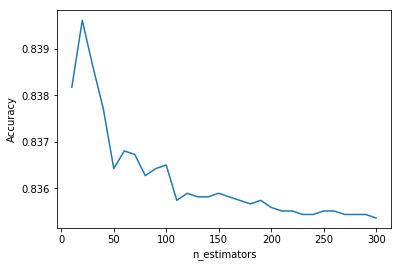

In [74]:
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')


Aproximadamente en 25, se encuentra el mejor estimador

##### max_features

In [75]:
# list of values to try for max_features
feature_range = range(1, X_train.shape[1]+1)

# list to store the average Accuracy for each value of max_features
accuracy_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=25, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

Text(0,0.5,'Accuracy')

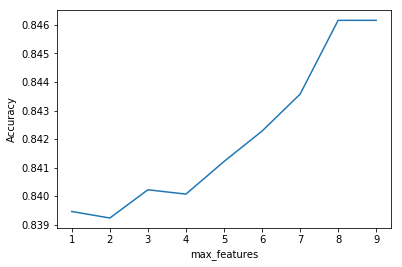

In [76]:
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

Mejor accuracy de las  variables es 9

##### max_depth

In [78]:
# list of values to try for max_features
depths = range(1, 30)

# list to store the average Accuracy for each value of max_features
accuracy_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for depth in depths:
    clf = RandomForestClassifier(n_estimators=25,max_depth=depth ,random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

Text(0,0.5,'Accuracy')

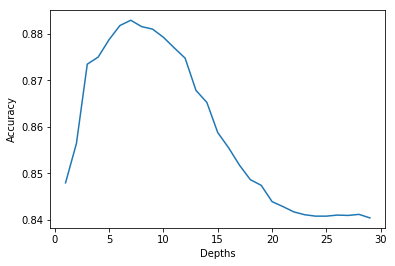

In [79]:
plt.plot(depths, accuracy_scores)
plt.xlabel('Depths')
plt.ylabel('Accuracy')

In [80]:
depth_df=pd.DataFrame(accuracy_scores, columns=['Accuracy'], index=range(1, 30)) 
result = depth_df.sort_values(['Accuracy'], ascending=[0])
result

,Accuracy
7,0.882890
6,0.881750
8,0.881522
9,0.880989
10,0.879240
5,0.878708
11,0.876958
4,0.874981
12,0.874753
3,0.873460


Finalmente se genera el modelo con los mejores resultados

In [84]:
clf = RandomForestClassifier(n_estimators=25, max_features=8,max_depth=7, random_state=1, n_jobs=-1)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

In [85]:
print("F1:",metrics.f1_score(y_pred, y_test))
print("Accuracy:",metrics.accuracy_score(y_pred, y_test))

('F1:', 0.8970986460348163)
('Accuracy:', 0.8774193548387097)
